<a href="https://colab.research.google.com/github/aymenhmid/NLP_Guide/blob/main/Naive_Bayes_classifier_for_spam_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Baseline Model

In [16]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, ComplementNB, BernoulliNB
from sklearn.metrics import classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.pipeline import Pipeline
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
import re
import matplotlib.pyplot as plt
from sklearn.calibration import CalibratedClassifierCV
import seaborn as sns

# Sample email dataset for spam detection (expanded)


# Convert to DataFrame
# the dataset used is available on kaggle "https://www.kaggle.com/datasets/venky73/spam-mails-dataset?select=spam_ham_dataset.csv"
df = pd.read_csv('/content/spam_ham_dataset.csv')
print(f"Dataset size: {len(df)} emails")
print(f"Class distribution: {df['label'].value_counts().to_dict()}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    df['text'], df['label'], test_size=0.3, random_state=42
)

print(f"Training set: {len(X_train)} emails")
print(f"Testing set: {len(X_test)} emails")

# Function to evaluate and store results
def evaluate_model(y_true, y_pred, model_name):
    accuracy = accuracy_score(y_true, y_pred)
    precision = precision_score(y_true, y_pred, pos_label='spam')
    recall = recall_score(y_true, y_pred, pos_label='spam')
    f1 = f1_score(y_true, y_pred, pos_label='spam')

    print(f"\n{model_name} Performance:")
    print(f"Accuracy:  {accuracy:.4f}")
    print(f"Precision: {precision:.4f}")
    print(f"Recall:    {recall:.4f}")
    print(f"F1 Score:  {f1:.4f}")
    print(classification_report(y_true, y_pred))

    return {
        'Model': model_name,
        'Accuracy': accuracy,
        'Precision': precision,
        'Recall': recall,
        'F1 Score': f1
    }

# Store results for comparison
results = []

print("\n====================================")
print("BASELINE MODEL")
print("====================================")
print("Basic Naive Bayes with Count Vectorizer (bag-of-words)")
# Baseline model
vectorizer = CountVectorizer()
X_train_bow = vectorizer.fit_transform(X_train)
X_test_bow = vectorizer.transform(X_test)

nb_baseline = MultinomialNB()
nb_baseline.fit(X_train_bow, y_train)
y_pred_baseline = nb_baseline.predict(X_test_bow)

baseline_results = evaluate_model(y_test, y_pred_baseline, "Baseline NB")
results.append(baseline_results)


Dataset size: 5171 emails
Class distribution: {'ham': 3672, 'spam': 1499}
Training set: 3619 emails
Testing set: 1552 emails

BASELINE MODEL
Basic Naive Bayes with Count Vectorizer (bag-of-words)

Baseline NB Performance:
Accuracy:  0.9742
Precision: 0.9578
Recall:    0.9490
F1 Score:  0.9534
              precision    recall  f1-score   support

         ham       0.98      0.98      0.98      1121
        spam       0.96      0.95      0.95       431

    accuracy                           0.97      1552
   macro avg       0.97      0.97      0.97      1552
weighted avg       0.97      0.97      0.97      1552



##apply basic text preprocessing

In [17]:
!pip install nltk
import nltk

nltk.download('punkt_tab')
nltk.download('wordnet')

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [18]:
print("\n====================================")
print("TECHNIQUE 1: BASIC TEXT PREPROCESSING")
print("====================================")

class TextPreprocessor:
    def __init__(self):
        self.lemmatizer = WordNetLemmatizer()

    def preprocess(self, text):
        # Convert to lowercase
        text = text.lower()

        # Remove special characters and numbers
        text = re.sub(r'[^a-zA-Z\s]', '', text)

        # Tokenize
        tokens = word_tokenize(text)

        # Lemmatization
        tokens = [self.lemmatizer.lemmatize(token) for token in tokens]

        # Join tokens back
        return ' '.join(tokens)

# Apply preprocessing to our dataset
preprocessor = TextPreprocessor()
X_train_preprocessed = X_train.apply(preprocessor.preprocess)
X_test_preprocessed = X_test.apply(preprocessor.preprocess)

# Show preprocessing effect
print("\nOriginal vs Preprocessed examples:")
for i in range(2):
    print(f"Original:    {X_train.iloc[i]}")
    print(f"Preprocessed: {X_train_preprocessed.iloc[i]}")
    print()

# Apply basic Naive Bayes with preprocessing
vectorizer = CountVectorizer()
X_train_prep_bow = vectorizer.fit_transform(X_train_preprocessed)
X_test_prep_bow = vectorizer.transform(X_test_preprocessed)

nb_preprocessed = MultinomialNB()
nb_preprocessed.fit(X_train_prep_bow, y_train)
y_pred_preprocessed = nb_preprocessed.predict(X_test_prep_bow)

preprocessing_results = evaluate_model(y_test, y_pred_preprocessed, "NB + Preprocessing")
results.append(preprocessing_results)


TECHNIQUE 1: BASIC TEXT PREPROCESSING

Original vs Preprocessed examples:
Original:    Subject: re : tenaska
i see the demand fee changes and the williams price change . that all looks
great , but i still have a problem with the apache prices . for 10 / 00 and
11 / 00 , we have a price of 2 . 285 for deal 384247 . apache billed 2 . 175 for
both months . are we going to change the apache prices ?
megan
Preprocessed: subject re tenaska i see the demand fee change and the williams price change that all look great but i still have a problem with the apache price for and we have a price of for deal apache billed for both month are we going to change the apache price megan

Original:    Subject: strong buy alert : monthly newsletter
topstocks mid - week report
alert :
strong buy / watch
issued on cwtd
* * * braking end of market news announcement * * *
* * wednesday may 19 ,
6 : 14 pm et
* *
braking news ;
wednesday may 19 , 6 : 14 pm et
china world trade corp . signs agreement with huahao


##add stopwords removal

In [19]:
print("\n====================================")
print("TECHNIQUE 2: ADDING STOPWORDS REMOVAL")
print("====================================")

# Remove stopwords and use preprocessing
vectorizer_stop = CountVectorizer(stop_words='english')
X_train_stop = vectorizer_stop.fit_transform(X_train_preprocessed)
X_test_stop = vectorizer_stop.transform(X_test_preprocessed)

nb_stop = MultinomialNB()
nb_stop.fit(X_train_stop, y_train)
y_pred_stop = nb_stop.predict(X_test_stop)

# Show stopwords effect
print("\nFeature size without stopwords removal:", vectorizer.get_feature_names_out().shape[0])
print("Feature size with stopwords removal:", vectorizer_stop.get_feature_names_out().shape[0])
print("Stopwords removed:", vectorizer.get_feature_names_out().shape[0] - vectorizer_stop.get_feature_names_out().shape[0])

stopwords_results = evaluate_model(y_test, y_pred_stop, "NB + Preprocessing + Stopwords")
results.append(stopwords_results)



TECHNIQUE 2: ADDING STOPWORDS REMOVAL

Feature size without stopwords removal: 35456
Feature size with stopwords removal: 35154
Stopwords removed: 302

NB + Preprocessing + Stopwords Performance:
Accuracy:  0.9723
Precision: 0.9554
Recall:    0.9443
F1 Score:  0.9498
              precision    recall  f1-score   support

         ham       0.98      0.98      0.98      1121
        spam       0.96      0.94      0.95       431

    accuracy                           0.97      1552
   macro avg       0.97      0.96      0.97      1552
weighted avg       0.97      0.97      0.97      1552



##Apply TF-IDF

In [20]:
print("\n====================================")
print("TECHNIQUE 3: USING TF-IDF INSTEAD OF COUNT VECTORIZER")
print("====================================")

# TF-IDF approach
tfidf_vectorizer = TfidfVectorizer(stop_words='english')
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train_preprocessed)
X_test_tfidf = tfidf_vectorizer.transform(X_test_preprocessed)

nb_tfidf = MultinomialNB()
nb_tfidf.fit(X_train_tfidf, y_train)
y_pred_tfidf = nb_tfidf.predict(X_test_tfidf)

# Compare feature representation for a sample
sample_idx = 0
sample_text = X_train_preprocessed.iloc[sample_idx]
print(f"\nSample text: '{sample_text}'")

print("\nBag of Words vs TF-IDF comparison for top features:")
sample_bow = vectorizer_stop.transform([sample_text]).toarray()[0]
sample_tfidf = tfidf_vectorizer.transform([sample_text]).toarray()[0]

bow_indices = np.argsort(sample_bow)[-5:]
tfidf_indices = np.argsort(sample_tfidf)[-5:]

print("Top BOW features:")
for idx in bow_indices:
    if sample_bow[idx] > 0:  # Only show non-zero features
        feature_name = vectorizer_stop.get_feature_names_out()[idx]
        print(f"  - '{feature_name}': {sample_bow[idx]}")

print("\nTop TF-IDF features:")
for idx in tfidf_indices:
    if sample_tfidf[idx] > 0:  # Only show non-zero features
        feature_name = tfidf_vectorizer.get_feature_names_out()[idx]
        print(f"  - '{feature_name}': {sample_tfidf[idx]:.4f}")

tfidf_results = evaluate_model(y_test, y_pred_tfidf, "NB + Preprocessing + Stopwords + TF-IDF")
results.append(tfidf_results)


TECHNIQUE 3: USING TF-IDF INSTEAD OF COUNT VECTORIZER

Sample text: 'subject re tenaska i see the demand fee change and the williams price change that all look great but i still have a problem with the apache price for and we have a price of for deal apache billed for both month are we going to change the apache price megan'

Bag of Words vs TF-IDF comparison for top features:
Top BOW features:
  - 'tenaska': 1
  - 'month': 1
  - 'change': 3
  - 'apache': 3
  - 'price': 4

Top TF-IDF features:
  - 'williams': 0.1994
  - 'billed': 0.2097
  - 'change': 0.3418
  - 'price': 0.4537
  - 'apache': 0.6058

NB + Preprocessing + Stopwords + TF-IDF Performance:
Accuracy:  0.9278
Precision: 0.9969
Recall:    0.7425
F1 Score:  0.8511
              precision    recall  f1-score   support

         ham       0.91      1.00      0.95      1121
        spam       1.00      0.74      0.85       431

    accuracy                           0.93      1552
   macro avg       0.95      0.87      0.90      1

## add N-grams

In [21]:
print("\n====================================")
print("TECHNIQUE 4: ADDING N-GRAMS")
print("====================================")

# Using both unigrams and bigrams
ngram_vectorizer = TfidfVectorizer(stop_words='english', ngram_range=(1, 2))
X_train_ngram = ngram_vectorizer.fit_transform(X_train_preprocessed)
X_test_ngram = ngram_vectorizer.transform(X_test_preprocessed)

nb_ngram = MultinomialNB()
nb_ngram.fit(X_train_ngram, y_train)
y_pred_ngram = nb_ngram.predict(X_test_ngram)

# Show some examples of bigram features
bigram_features = [f for f in ngram_vectorizer.get_feature_names_out() if ' ' in f]
print(f"\nTotal features: {len(ngram_vectorizer.get_feature_names_out())}")
print(f"Unigram features: {len(ngram_vectorizer.get_feature_names_out()) - len(bigram_features)}")
print(f"Bigram features: {len(bigram_features)}")
print("\nSample bigram features:")
for feature in sorted(bigram_features)[:10]:
    print(f"  - '{feature}'")

ngram_results = evaluate_model(y_test, y_pred_ngram, "NB + Preprocessing + Stopwords + TF-IDF + N-grams")
results.append(ngram_results)


TECHNIQUE 4: ADDING N-GRAMS

Total features: 197432
Unigram features: 35154
Bigram features: 162278

Sample bigram features:
  - 'aa cc'
  - 'aa check'
  - 'aa day'
  - 'aa delivered'
  - 'aa end'
  - 'aa headcount'
  - 'aa la'
  - 'aa rockky'
  - 'aaa draftee'
  - 'aabda bl'

NB + Preprocessing + Stopwords + TF-IDF + N-grams Performance:
Accuracy:  0.9027
Precision: 1.0000
Recall:    0.6497
F1 Score:  0.7876
              precision    recall  f1-score   support

         ham       0.88      1.00      0.94      1121
        spam       1.00      0.65      0.79       431

    accuracy                           0.90      1552
   macro avg       0.94      0.82      0.86      1552
weighted avg       0.91      0.90      0.90      1552



##Alpha smoothing optimization

In [22]:
print("\n====================================")
print("TECHNIQUE 5: ALPHA SMOOTHING OPTIMIZATION")
print("====================================")

# Test different alpha values
alpha_values = [0.001, 0.01, 0.1, 0.5, 1.0, 2.0, 5.0, 10.0]
alpha_scores = []

print("\nTesting different alpha smoothing values:")
for a in alpha_values:
    nb_alpha = MultinomialNB(alpha=a)
    nb_alpha.fit(X_train_ngram, y_train)
    y_pred_alpha = nb_alpha.predict(X_test_ngram)
    accuracy = accuracy_score(y_test, y_pred_alpha)
    alpha_scores.append(accuracy)
    print(f"Alpha = {a}: Accuracy = {accuracy:.4f}")

# Find best alpha
best_alpha = alpha_values[np.argmax(alpha_scores)]
print(f"\nBest alpha value: {best_alpha}")

# Use best alpha
nb_best_alpha = MultinomialNB(alpha=best_alpha)
nb_best_alpha.fit(X_train_ngram, y_train)
y_pred_best_alpha = nb_best_alpha.predict(X_test_ngram)

alpha_results = evaluate_model(y_test, y_pred_best_alpha, f"NB + Preprocessing + Stopwords + TF-IDF + N-grams + Alpha={best_alpha}")
results.append(alpha_results)


TECHNIQUE 5: ALPHA SMOOTHING OPTIMIZATION

Testing different alpha smoothing values:
Alpha = 0.001: Accuracy = 0.9871
Alpha = 0.01: Accuracy = 0.9865
Alpha = 0.1: Accuracy = 0.9832
Alpha = 0.5: Accuracy = 0.9446
Alpha = 1.0: Accuracy = 0.9027
Alpha = 2.0: Accuracy = 0.8473
Alpha = 5.0: Accuracy = 0.7668
Alpha = 10.0: Accuracy = 0.7339

Best alpha value: 0.001

NB + Preprocessing + Stopwords + TF-IDF + N-grams + Alpha=0.001 Performance:
Accuracy:  0.9871
Precision: 0.9768
Recall:    0.9768
F1 Score:  0.9768
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99      1121
        spam       0.98      0.98      0.98       431

    accuracy                           0.99      1552
   macro avg       0.98      0.98      0.98      1552
weighted avg       0.99      0.99      0.99      1552



##Try different NB variants

In [23]:
print("\n====================================")
print("TECHNIQUE 6: TRY DIFFERENT NAIVE BAYES VARIANTS")
print("====================================")

# BernoulliNB (focuses on presence/absence, not count)
bnb = BernoulliNB(alpha=best_alpha)
bnb.fit(X_train_ngram, y_train)
y_pred_bnb = bnb.predict(X_test_ngram)

# ComplementNB (especially good for imbalanced datasets)
cnb = ComplementNB(alpha=best_alpha)
cnb.fit(X_train_ngram, y_train)
y_pred_cnb = cnb.predict(X_test_ngram)

print("\nMultinomialNB vs BernoulliNB vs ComplementNB:")

mnb_results = evaluate_model(y_test, y_pred_best_alpha, "MultinomialNB (Previous Best)")
bnb_results = evaluate_model(y_test, y_pred_bnb, "BernoulliNB")
cnb_results = evaluate_model(y_test, y_pred_cnb, "ComplementNB")

# Add BernoulliNB or ComplementNB to results if better
if bnb_results['Accuracy'] > mnb_results['Accuracy'] and bnb_results['Accuracy'] > cnb_results['Accuracy']:
    results.append(bnb_results)
    best_nb_variant = "BernoulliNB"
    best_variant_pred = y_pred_bnb
elif cnb_results['Accuracy'] > mnb_results['Accuracy']:
    results.append(cnb_results)
    best_nb_variant = "ComplementNB"
    best_variant_pred = y_pred_cnb
else:
    best_nb_variant = "MultinomialNB"
    best_variant_pred = y_pred_best_alpha

print(f"\nBest Naive Bayes variant: {best_nb_variant}")


TECHNIQUE 6: TRY DIFFERENT NAIVE BAYES VARIANTS

MultinomialNB vs BernoulliNB vs ComplementNB:

MultinomialNB (Previous Best) Performance:
Accuracy:  0.9871
Precision: 0.9768
Recall:    0.9768
F1 Score:  0.9768
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99      1121
        spam       0.98      0.98      0.98       431

    accuracy                           0.99      1552
   macro avg       0.98      0.98      0.98      1552
weighted avg       0.99      0.99      0.99      1552


BernoulliNB Performance:
Accuracy:  0.9298
Precision: 0.9849
Recall:    0.7587
F1 Score:  0.8571
              precision    recall  f1-score   support

         ham       0.91      1.00      0.95      1121
        spam       0.98      0.76      0.86       431

    accuracy                           0.93      1552
   macro avg       0.95      0.88      0.91      1552
weighted avg       0.93      0.93      0.93      1552


ComplementNB Performance:
Accuracy:

##Probability calibration

In [24]:
print("\n====================================")
print("TECHNIQUE 7: PROBABILITY CALIBRATION")
print("====================================")

# Select the best NB variant from previous step
if best_nb_variant == "MultinomialNB":
    base_clf = MultinomialNB(alpha=best_alpha)
elif best_nb_variant == "BernoulliNB":
    base_clf = BernoulliNB(alpha=best_alpha)
else:
    base_clf = ComplementNB(alpha=best_alpha)

# Use calibration
calibrated_clf = CalibratedClassifierCV(base_clf, cv=3, method='sigmoid')
calibrated_clf.fit(X_train_ngram, y_train)
y_pred_calibrated = calibrated_clf.predict(X_test_ngram)

# Compare probability outputs
print("\nComparing probability outputs for a test sample:")
sample_idx = 0
sample_text = X_test_preprocessed.iloc[sample_idx]
sample_features = ngram_vectorizer.transform([sample_text])

# Get base model
base_model = base_clf.fit(X_train_ngram, y_train)

# Original probabilities
original_probs = base_model.predict_proba(sample_features)[0]
# Calibrated probabilities
calibrated_probs = calibrated_clf.predict_proba(sample_features)[0]

print(f"Text: '{X_test.iloc[sample_idx]}'")
print(f"True label: {y_test.iloc[sample_idx]}")
print(f"Original probabilities: [ham: {original_probs[0]:.4f}, spam: {original_probs[1]:.4f}]")
print(f"Calibrated probabilities: [ham: {calibrated_probs[0]:.4f}, spam: {calibrated_probs[1]:.4f}]")

calibrated_results = evaluate_model(y_test, y_pred_calibrated, f"Calibrated {best_nb_variant}")
results.append(calibrated_results)


TECHNIQUE 7: PROBABILITY CALIBRATION

Comparing probability outputs for a test sample:
Text: 'Subject: hpl nom for march 30 , 2001
( see attached file : hplno 330 . xls )
- hplno 330 . xls'
True label: ham
Original probabilities: [ham: 1.0000, spam: 0.0000]
Calibrated probabilities: [ham: 0.9952, spam: 0.0048]

Calibrated MultinomialNB Performance:
Accuracy:  0.9878
Precision: 0.9836
Recall:    0.9722
F1 Score:  0.9778
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99      1121
        spam       0.98      0.97      0.98       431

    accuracy                           0.99      1552
   macro avg       0.99      0.98      0.98      1552
weighted avg       0.99      0.99      0.99      1552



##ensemble approach

In [25]:
print("\n====================================")
print("TECHNIQUE 8: ENSEMBLE APPROACH")
print("====================================")

# Create a simple ensemble (voting)
from sklearn.ensemble import VotingClassifier

# Create ensemble with the best configurations of each variant
ensemble = VotingClassifier(
    estimators=[
        ('mnb', MultinomialNB(alpha=best_alpha)),
        ('bnb', BernoulliNB(alpha=best_alpha)),
        ('cnb', ComplementNB(alpha=best_alpha))
    ],
    voting='soft'  # Use probability estimates for voting
)

# Train ensemble
ensemble.fit(X_train_ngram, y_train)
y_pred_ensemble = ensemble.predict(X_test_ngram)

ensemble_results = evaluate_model(y_test, y_pred_ensemble, "Ensemble of NB variants")
results.append(ensemble_results)



TECHNIQUE 8: ENSEMBLE APPROACH

Ensemble of NB variants Performance:
Accuracy:  0.9865
Precision: 0.9812
Recall:    0.9698
F1 Score:  0.9755
              precision    recall  f1-score   support

         ham       0.99      0.99      0.99      1121
        spam       0.98      0.97      0.98       431

    accuracy                           0.99      1552
   macro avg       0.98      0.98      0.98      1552
weighted avg       0.99      0.99      0.99      1552



##Add custom text features

In [27]:
print("\n====================================")
print("TECHNIQUE 9: ADD CUSTOM TEXT FEATURES")
print("====================================")

# Extract text-based custom features
def extract_text_features(texts):
    features = []
    for text in texts:
        # Custom features
        length = len(text)
        word_count = len(text.split())
        avg_word_length = length / max(word_count, 1)
        has_numbers = any(c.isdigit() for c in text)
        uppercase_ratio = sum(1 for c in text if c.isupper()) / max(length, 1)

        features.append([length, word_count, avg_word_length,
                        int(has_numbers), uppercase_ratio])
    return np.array(features)

# Extract features from preprocessed text
X_train_custom = extract_text_features(X_train)
X_test_custom = extract_text_features(X_test)

# Print custom feature stats
print("\nCustom feature statistics:")
feature_names = ['Text length', 'Word count', 'Avg word length', 'Has numbers', 'Uppercase ratio']
for i, name in enumerate(feature_names):
    train_mean = X_train_custom[:, i].mean()
    spam_mean = X_train_custom[y_train == 'spam', i].mean()
    ham_mean = X_train_custom[y_train == 'ham', i].mean()
    print(f"{name}: Overall avg: {train_mean:.4f}, Spam avg: {spam_mean:.4f}, Ham avg: {ham_mean:.4f}")

# Train on custom features alone
from sklearn.preprocessing import StandardScaler

# Scale custom features
scaler = StandardScaler()
X_train_custom_scaled = scaler.fit_transform(X_train_custom)
X_test_custom_scaled = scaler.transform(X_test_custom)

# Try NB on just custom features first
nb_custom = MultinomialNB(alpha=best_alpha)
nb_custom.fit(np.absolute(X_train_custom_scaled), y_train)  # Take abs because custom features may be negative
y_pred_custom = nb_custom.predict(np.absolute(X_test_custom_scaled))

custom_only_results = evaluate_model(y_test, y_pred_custom, "NB with only custom features")

# Now combine with text features
from scipy.sparse import hstack, csr_matrix

X_train_combined = hstack([X_train_ngram, csr_matrix(X_train_custom_scaled)])
X_test_combined = hstack([X_test_ngram, csr_matrix(X_test_custom_scaled)])

# Best NB variant on combined features
if best_nb_variant == "MultinomialNB":
    best_nb = MultinomialNB(alpha=best_alpha)
elif best_nb_variant == "BernoulliNB":
    best_nb = BernoulliNB(alpha=best_alpha)
else:
    best_nb = ComplementNB(alpha=best_alpha)

#best_nb.fit(X_train_combined, y_train)
#y_pred_combined = best_nb.predict(X_test_combined)
#Scaling can result in negative values, which are not compatible with the MultinomialNB model so we apply np.abs to avoid error
best_nb.fit(np.abs(X_train_combined.toarray()), y_train) # Convert to dense array and apply np.abs
y_pred_combined = best_nb.predict(np.abs(X_test_combined.toarray())) # Convert to dense array and apply np.abs


combined_results = evaluate_model(y_test, y_pred_combined, f"{best_nb_variant} with combined features")
results.append(combined_results)


TECHNIQUE 9: ADD CUSTOM TEXT FEATURES

Custom feature statistics:
Text length: Overall avg: 1042.7488, Spam avg: 1229.9242, Ham avg: 964.3861
Word count: Overall avg: 225.5681, Spam avg: 233.6498, Ham avg: 222.1846
Avg word length: Overall avg: 4.7099, Spam avg: 5.3179, Ham avg: 4.4553
Has numbers: Overall avg: 0.8759, Spam avg: 0.7612, Ham avg: 0.9240
Uppercase ratio: Overall avg: 0.0038, Spam avg: 0.0048, Ham avg: 0.0034

NB with only custom features Performance:
Accuracy:  0.7255
Precision: 0.8571
Recall:    0.0139
F1 Score:  0.0274
              precision    recall  f1-score   support

         ham       0.72      1.00      0.84      1121
        spam       0.86      0.01      0.03       431

    accuracy                           0.73      1552
   macro avg       0.79      0.51      0.43      1552
weighted avg       0.76      0.73      0.61      1552


MultinomialNB with combined features Performance:
Accuracy:  0.9878
Precision: 0.9725
Recall:    0.9838
F1 Score:  0.9781
       

##Results comparison


FINAL RESULTS COMPARISON
                                                          Model  Accuracy  Precision   Recall  F1 Score
                                                    Baseline NB  0.974227   0.957845 0.948956  0.953380
                                             NB + Preprocessing  0.976160   0.964623 0.948956  0.956725
                                 NB + Preprocessing + Stopwords  0.972294   0.955399 0.944316  0.949825
                        NB + Preprocessing + Stopwords + TF-IDF  0.927835   0.996885 0.742459  0.851064
              NB + Preprocessing + Stopwords + TF-IDF + N-grams  0.902706   1.000000 0.649652  0.787623
NB + Preprocessing + Stopwords + TF-IDF + N-grams + Alpha=0.001  0.987113   0.976798 0.976798  0.976798
                                       Calibrated MultinomialNB  0.987758   0.983568 0.972158  0.977830
                                        Ensemble of NB variants  0.986469   0.981221 0.969838  0.975496
                           Multinomial

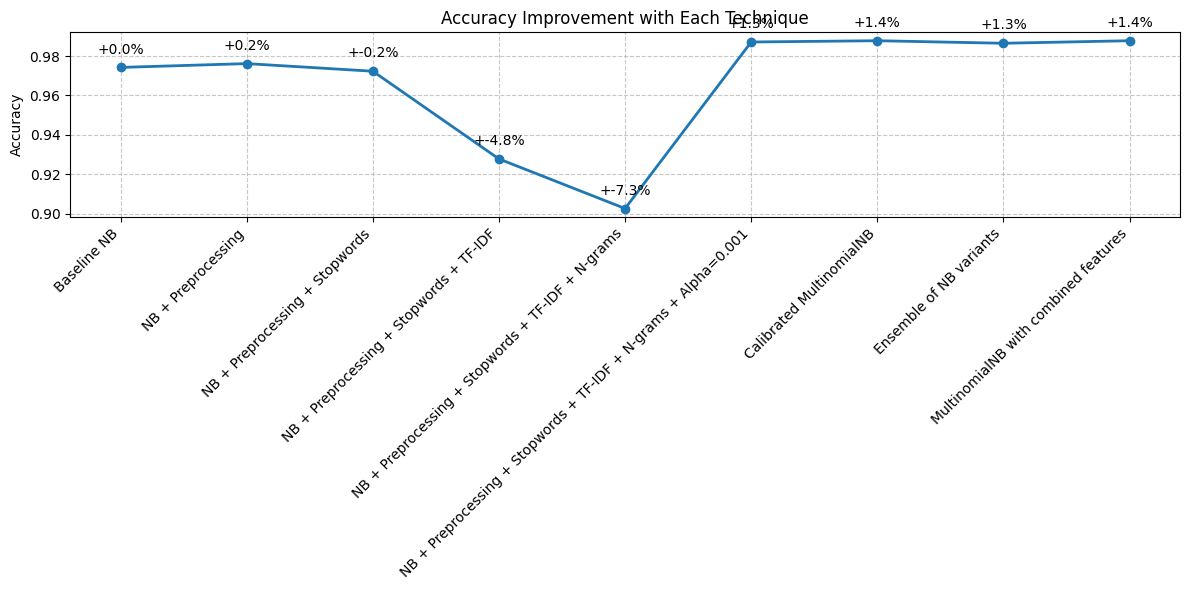

In [28]:
print("\n====================================")
print("FINAL RESULTS COMPARISON")
print("====================================")

# Convert results to DataFrame for easier comparison
results_df = pd.DataFrame(results)
print(results_df.to_string(index=False))

# Calculate improvements
baseline_accuracy = results_df.iloc[0]['Accuracy']
improvements = [(r['Accuracy'] - baseline_accuracy) / baseline_accuracy * 100 for r in results]
for i, model in enumerate(results_df['Model']):
    print(f"{model}: {improvements[i]:.2f}% improvement over baseline")

# Find best model
best_model_idx = results_df['Accuracy'].idxmax()
print(f"\nBest model: {results_df.loc[best_model_idx, 'Model']}")
print(f"Best accuracy: {results_df.loc[best_model_idx, 'Accuracy']:.4f}")
print(f"Improvement over baseline: {improvements[best_model_idx]:.2f}%")

# Plot accuracy progression
plt.figure(figsize=(12, 6))
plt.plot(range(len(results)), [r['Accuracy'] for r in results], marker='o', linestyle='-', linewidth=2)
plt.xticks(range(len(results)), [r['Model'] for r in results], rotation=45, ha='right')
plt.ylabel('Accuracy')
plt.title('Accuracy Improvement with Each Technique')
plt.tight_layout()
plt.grid(True, linestyle='--', alpha=0.7)

# Add improvement percentages to the plot
for i, improvement in enumerate(improvements):
    plt.annotate(f"+{improvement:.1f}%",
                 xy=(i, results[i]['Accuracy']),
                 xytext=(0, 10),
                 textcoords='offset points',
                 ha='center')

plt.savefig("naive_bayes_improvements.png")  # Save the plot
print("\nAccuracy progression plot saved as 'naive_bayes_improvements.png'")